In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import hyperopt
import time
import sklearn.metrics as mt
import pickle

from xgboost import Booster
from xgboost import XGBClassifier
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier

C:\Users\marsl\anaconda3\envs\ML\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
#################################################################################################
###### The function load_window_dataset() that takes in input window data file, and 
###### label to be assigned and returns numpy arrays with features and labels
#################################################################################################

def load_window_dataset(X, y, filename, label):
#Inputs: - X: current matrix of datapoints where we want to APPEND the datapoints retrieved from filename (only features)
#        - y: current matrix of datapoints where we want to APPEND the datapoints retrieved from filename (only labels)
#        - filename: full name (with path) of the file to be read (it must be a window dataset file created above)
#        - label: integer, label to be assigned to the datapoints retrieved from filename; it may differ from labels already included in current y
#Outputs: - X: updated X (including features for the new data points retrieved from filename)
#         - y: updated y (including labels for the new data points)
#This function to X and y in input the new datapoints retrieved from filename and return updated X and y
#The function handle the case when X and y are empty (initialized as None)

    data = pd.read_csv(filename)

    if X is None:
        X = data.to_numpy()
        # full() function puts in all X.shape[0] elements the value "label"
        y = np.full(X.shape[0], label)
    else:
        X_temp = data.to_numpy()
        y_temp = np.full(X_temp.shape[0], label)
        X = np.append(X, X_temp, axis = 0) #F: axis=0-->stack X and X_temp vertically (increase no of rows)
        y = np.append(y, y_temp)

    return X, y



In [4]:
##########################################################################################
###### Use function load_window_dataset() with datasets of for all scenarios  
###### using window length = 10 and spacing = 1. Finally, perform features scaling 
##########################################################################################

X=None 
y=None
length=10
spacing=1
folderpath='../Features_raw'

for filename in os.listdir(folderpath):   
    if filename.endswith('_sp' + str(spacing) + '_w' + str(length) + '.dat'):
        print(filename)
        label = 0
        if int(filename[9]) > 5:
          label = 1
        fullname = folderpath + '/' + filename
#------------------------------------------------------------
        X, y = load_window_dataset(X, y, fullname, label)
#------------------------------------------------------------
        print('current shape of X: ' +str(X.shape))
        print('current shape of y: ' +str(y.shape))

#All scenario correlated ONLY TO "length" and "spacing" variables
print(X)
print(y)
print(X.shape)
print(y.shape)

# Features scaling 
scaler = StandardScaler()
X = scaler.fit_transform(X)

print(X)
print(y)
print(X.shape)
print(y.shape)



Scenario_1_monitor_node_1_preamp_lpth_2_1_sp1_w10.dat
current shape of X: (21591, 6)
current shape of y: (21591,)
Scenario_1_monitor_node_1_preamp_lpth_3-1_1_sp1_w10.dat
current shape of X: (43182, 6)
current shape of y: (43182,)
Scenario_1_monitor_node_1_preamp_lpth_3-2_1_sp1_w10.dat
current shape of X: (64773, 6)
current shape of y: (64773,)
Scenario_2_monitor_node_1_preamp_lpth_2_1_sp1_w10.dat
current shape of X: (86364, 6)
current shape of y: (86364,)
Scenario_2_monitor_node_1_preamp_lpth_3-1_1_sp1_w10.dat
current shape of X: (107955, 6)
current shape of y: (107955,)
Scenario_3_monitor_node_1_preamp_lpth_2_1_sp1_w10.dat
current shape of X: (129546, 6)
current shape of y: (129546,)
Scenario_4_monitor_node_1_preamp_lpth_2_1_sp1_w10.dat
current shape of X: (151137, 6)
current shape of y: (151137,)
Scenario_4_monitor_node_1_preamp_lpth_3-1_1_sp1_w10.dat
current shape of X: (172728, 6)
current shape of y: (172728,)
Scenario_4_monitor_node_1_preamp_lpth_3-2_1_sp1_w10.dat
current shape of

In [5]:
def train_classifier_XGB(X_train, y_train): 
    xgb = XGBClassifier(use_label_encoder=False, eta = 0.7, max_depth= 7, subsample = 1, verbosity = 0)

    # Execute the traning 3 times to be sure that the training time is correct
    ttimes = []
    for i in range(0, 3):
        t0 = time.time()
        xgb.fit(X_train, y_train)
        t1 = time.time()
        ex_time = t1 - t0
        ttimes.append(ex_time)
        print(ex_time)

    return xgb, ttimes


In [6]:
def train_classifier_DNN(X_train, y_train): 
    size = (50,) * 2
    dnn = MLPClassifier(hidden_layer_sizes=size, activation='tanh',
                        solver='adam', learning_rate='invscaling', max_iter=1000)


    # Execute the traning 3 times to be sure that the training time is correct
    ttimes = []
    for i in range(0, 3):
        t0 = time.time()
        dnn.fit(X_train, y_train)
        t1 = time.time()
        ex_time = t1 - t0
        ttimes.append(ex_time)

    return dnn, ttimes


In [7]:
def train_classifier_KNN(X_train, y_train): 
    knn = KNeighborsClassifier(leaf_size=43, p=1, n_neighbors=14)

    # Execute the traning 3 times to be sure that the training time is correct
    ttimes = []
    for i in range(0, 3):
        t0 = time.time()
        knn.fit(X_train, y_train)
        t1 = time.time()
        ex_time = t1 - t0
        ttimes.append(ex_time)
        print(ex_time)

    return knn, ttimes


In [8]:
################################################################################################################
###### Split into into train/test and call train_classifier_XXX() functions
################################################################################################################

# Stratify garantees the split all the scenarios among train and test
# It's like shuffle and split
# random_state it's a seed to get the same output

xgb_all_ttimes = []
dnn_all_ttimes = []
knn_all_ttimes = []

xgb_all_models = []
dnn_all_models = []
knn_all_models = []

all_X_train_X_test_y_train_y_test = []

percentages = [0.0003, 0.0005, 0.001, 0.005, 0.01, 0.02, 0.04, 0.06, 0.08, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9]

for i in percentages:
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=i, random_state=42)
    all_X_train_X_test_y_train_y_test.append([X_train, X_test, y_train, y_test])
    
    print(f'Training XGB with training size: {i*100}%...')
    xgb, xgb_ttimes = train_classifier_XGB(X_train, y_train)
    print(f'Training DNN with training size: {i*100}%...')
    dnn, dnn_ttimes = train_classifier_DNN(X_train, y_train)
    print(f'Training KNN with training size: {i*100}%...')
    knn, knn_ttimes = train_classifier_KNN(X_train, y_train)
    
    xgb_all_ttimes.append(xgb_ttimes)
    dnn_all_ttimes.append(dnn_ttimes)
    knn_all_ttimes.append(knn_ttimes)
    
    xgb_all_models.append(xgb)
    dnn_all_models.append(dnn)
    knn_all_models.append(knn)

Training XGB with training size: 0.03%...
0.04894590377807617
0.05000019073486328
0.05066871643066406
Training DNN with training size: 0.03%...
Training KNN with training size: 0.03%...
0.0009996891021728516
0.0009996891021728516
0.0009992122650146484
Training XGB with training size: 0.05%...
0.04355120658874512
0.05112767219543457
0.05777311325073242
Training DNN with training size: 0.05%...
Training KNN with training size: 0.05%...
0.000957489013671875
0.00099945068359375
0.0009992122650146484
Training XGB with training size: 0.1%...
0.04982185363769531
0.061594486236572266
0.05732417106628418
Training DNN with training size: 0.1%...
Training KNN with training size: 0.1%...
0.0009968280792236328
0.0009992122650146484
0.0009996891021728516
Training XGB with training size: 0.5%...
0.08965182304382324
0.07328581809997559
0.07200098037719727
Training DNN with training size: 0.5%...
Training KNN with training size: 0.5%...
0.003051280975341797
0.0019996166229248047
0.0030808448791503906
T

In [9]:
########################################################################################################
###### The function performance_eval() takes in input ground truth and predicted labels, 
###### prints results in a result file passed in input, and returns global metrics
########################################################################################################

def performance_eval(y_true, y_pred, lab, l_names):

    #Compute metrics and print/write them
    accuracy = mt.accuracy_score(y_true, y_pred)
    precision = mt.precision_score(y_true, y_pred, labels=lab, average=None) #F: average=None gives per-class results
    global_precision = mt.precision_score(y_true, y_pred, labels=lab, average='weighted') 
    recall = mt.recall_score(y_true, y_pred, labels=lab, average=None)
    global_recall = mt.recall_score(y_true, y_pred, labels=lab, average='weighted') 
    f1score = mt.f1_score(y_true, y_pred, labels=lab, average=None)
    global_f1score = mt.f1_score(y_true, y_pred, labels=lab, average='weighted')

    return accuracy, global_precision, global_recall, global_f1score 


In [10]:
lbl = [0, 1]
label_names=['Attenuation', 'Filtering']

XGB_all_metrics = []
DNN_all_metrics = []
KNN_all_metrics = []
    
for i, val in enumerate(percentages):
    X_train = all_X_train_X_test_y_train_y_test[i][0]
    X_test = all_X_train_X_test_y_train_y_test[i][1]
    y_train = all_X_train_X_test_y_train_y_test[i][2]
    y_test = all_X_train_X_test_y_train_y_test[i][3]
    
    # Added to fix: 'XGBClassifier' object has no attribute '_le'
    xgb._le = LabelEncoder().fit(y_test)

    y_pred_XGB = xgb_all_models[i].predict(X_test)
    y_pred_DNN = dnn_all_models[i].predict(X_test)
    y_pred_KNN = knn_all_models[i].predict(X_test)

    XGB_simgle_metrics = performance_eval(y_test, y_pred_XGB, lbl, label_names)
    DNN_single_metrics = performance_eval(y_test, y_pred_DNN, lbl, label_names)
    KNN_single_metrics = performance_eval(y_test, y_pred_KNN, lbl, label_names)

    XGB_all_metrics.append(XGB_simgle_metrics)
    DNN_all_metrics.append(DNN_single_metrics)
    KNN_all_metrics.append(KNN_single_metrics)

    print('XGB metrics for training size '+str(val*100)+ '%: '+str(XGB_simgle_metrics))
    print('****************')
    print('MLP metrics for training size '+str(val*100)+ '%: '+str(DNN_single_metrics))
    print('****************')
    print('KNN metrics for training size '+str(val*100)+ '%: '+str(KNN_single_metrics))

XGB metrics for training size 0.03%: (0.9924658641546038, 0.9925432279977482, 0.9924658641546038, 0.9924450505481046)
****************
MLP metrics for training size 0.03%: (0.9818908730718796, 0.9821153022535561, 0.9818908730718796, 0.9817948750716211)
****************
KNN metrics for training size 0.03%: (0.9615697484943276, 0.9636335973524794, 0.9615697484943276, 0.9609464535199664)
XGB metrics for training size 0.05%: (0.9918637629454718, 0.9919618438722553, 0.9918637629454718, 0.9918385860988318)
****************
MLP metrics for training size 0.05%: (0.9822080772044197, 0.9824982562281334, 0.9822080772044197, 0.9821046966145819)
****************
KNN metrics for training size 0.05%: (0.9684432067553868, 0.9696506482708266, 0.9684432067553868, 0.9680585809610233)
XGB metrics for training size 0.1%: (0.9893893482615171, 0.9893825158627388, 0.9893893482615171, 0.9893834373009933)
****************
MLP metrics for training size 0.1%: (0.9875019259411433, 0.9875885184531094, 0.98750192594

In [11]:
percentages_lables = [str(x*100)+'%' for x in percentages]
    
def candle_trainng_size_impact(fig_folder, alg_name, ttimes):
    global percentages
    global percentages_lables

    fig, ax = plt.subplots(figsize=(15,8))
    bplots = []
    n_perc = len(percentages)
    
    for i in range(n_perc):
        bplots.append(ax.boxplot(ttimes[i], positions = [i], patch_artist=True))

    for bplot in bplots:
        for patch in bplot['boxes']:
            patch.set_facecolor('lightblue')
    
    plt.xticks(color='black')
    plt.yticks(color='black')
    plt.grid(1)
    plt.xticks(ticks = list(range(n_perc)), labels = percentages_lables, fontsize = 14)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=-45, ha="left", rotation_mode="anchor") 
    plt.ylabel('Seconds', color='black', fontsize=14)
    plt.xlabel('Training set size percentage', color='black', fontsize=14)
    image_title=alg_name+' Training set size impact on Traning Time'
    plt.title(image_title, fontsize=14)
    plt.show()
    fig.savefig(fig_folder+'/'+image_title.replace(" ", "_")+'.png')

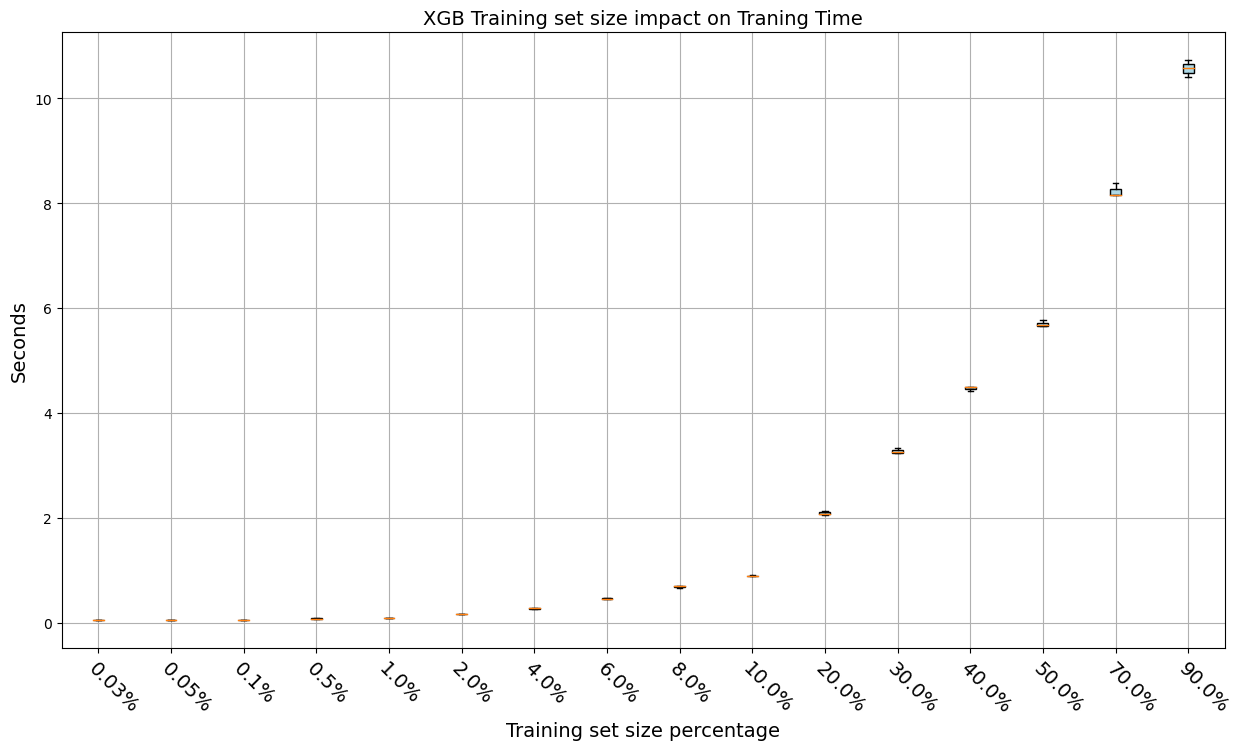

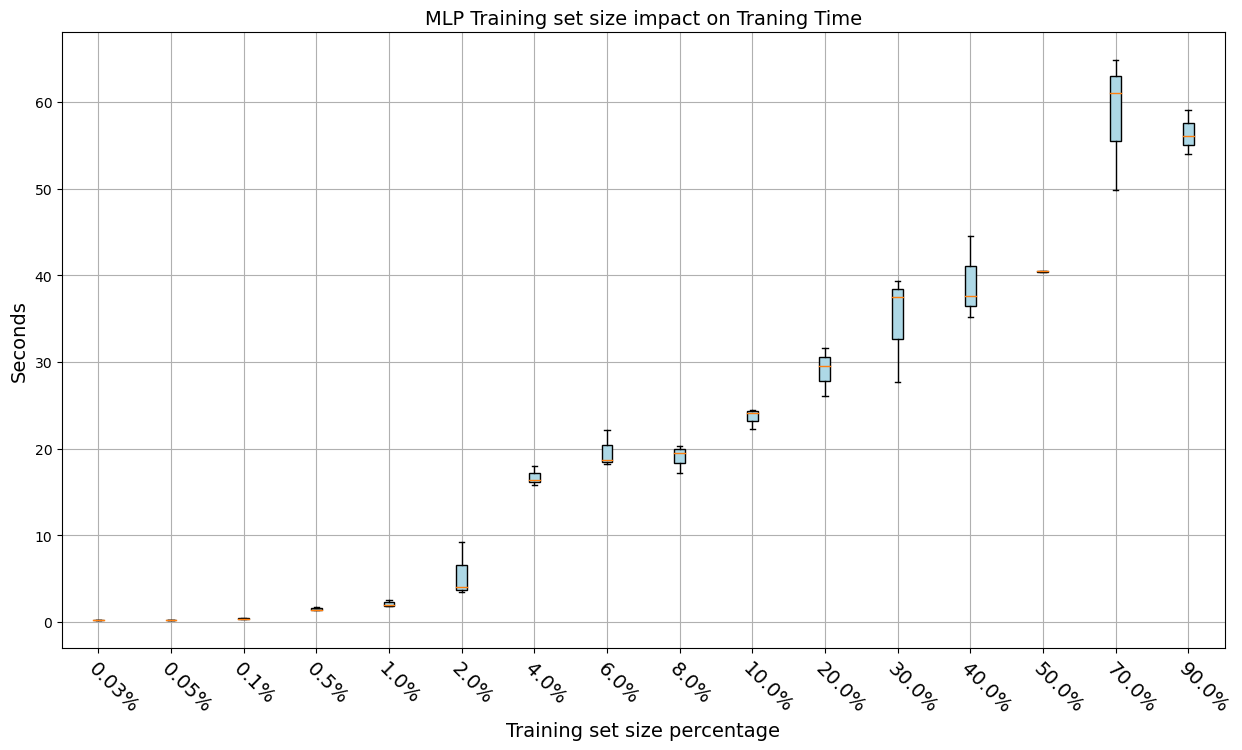

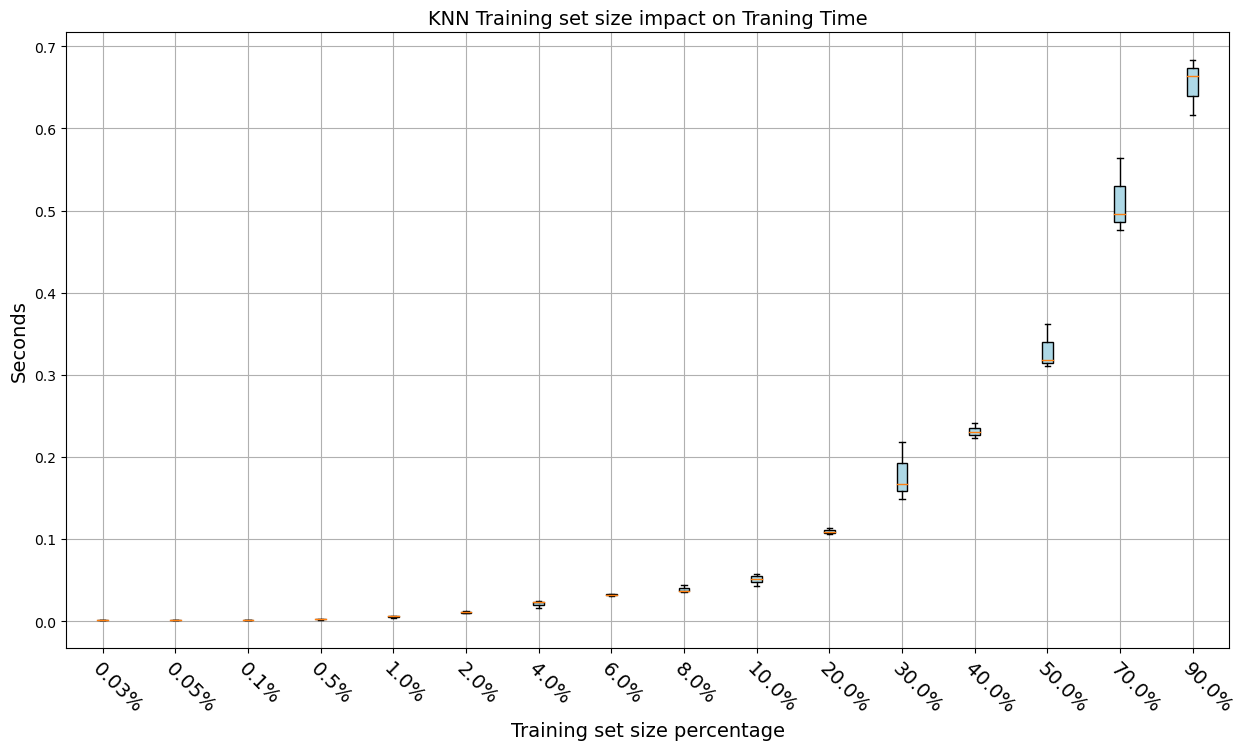

In [12]:
stats_labels = ['Accuracy', 'Global Precision', 'Global Recall', 'Global F1-score']

fig_folder = '1_4_Figures'
if not os.path.exists(fig_folder):
    os.makedirs(fig_folder)

candle_trainng_size_impact(fig_folder, 'XGB', xgb_all_ttimes)
candle_trainng_size_impact(fig_folder, 'MLP', dnn_all_ttimes)
candle_trainng_size_impact(fig_folder, 'KNN', knn_all_ttimes)

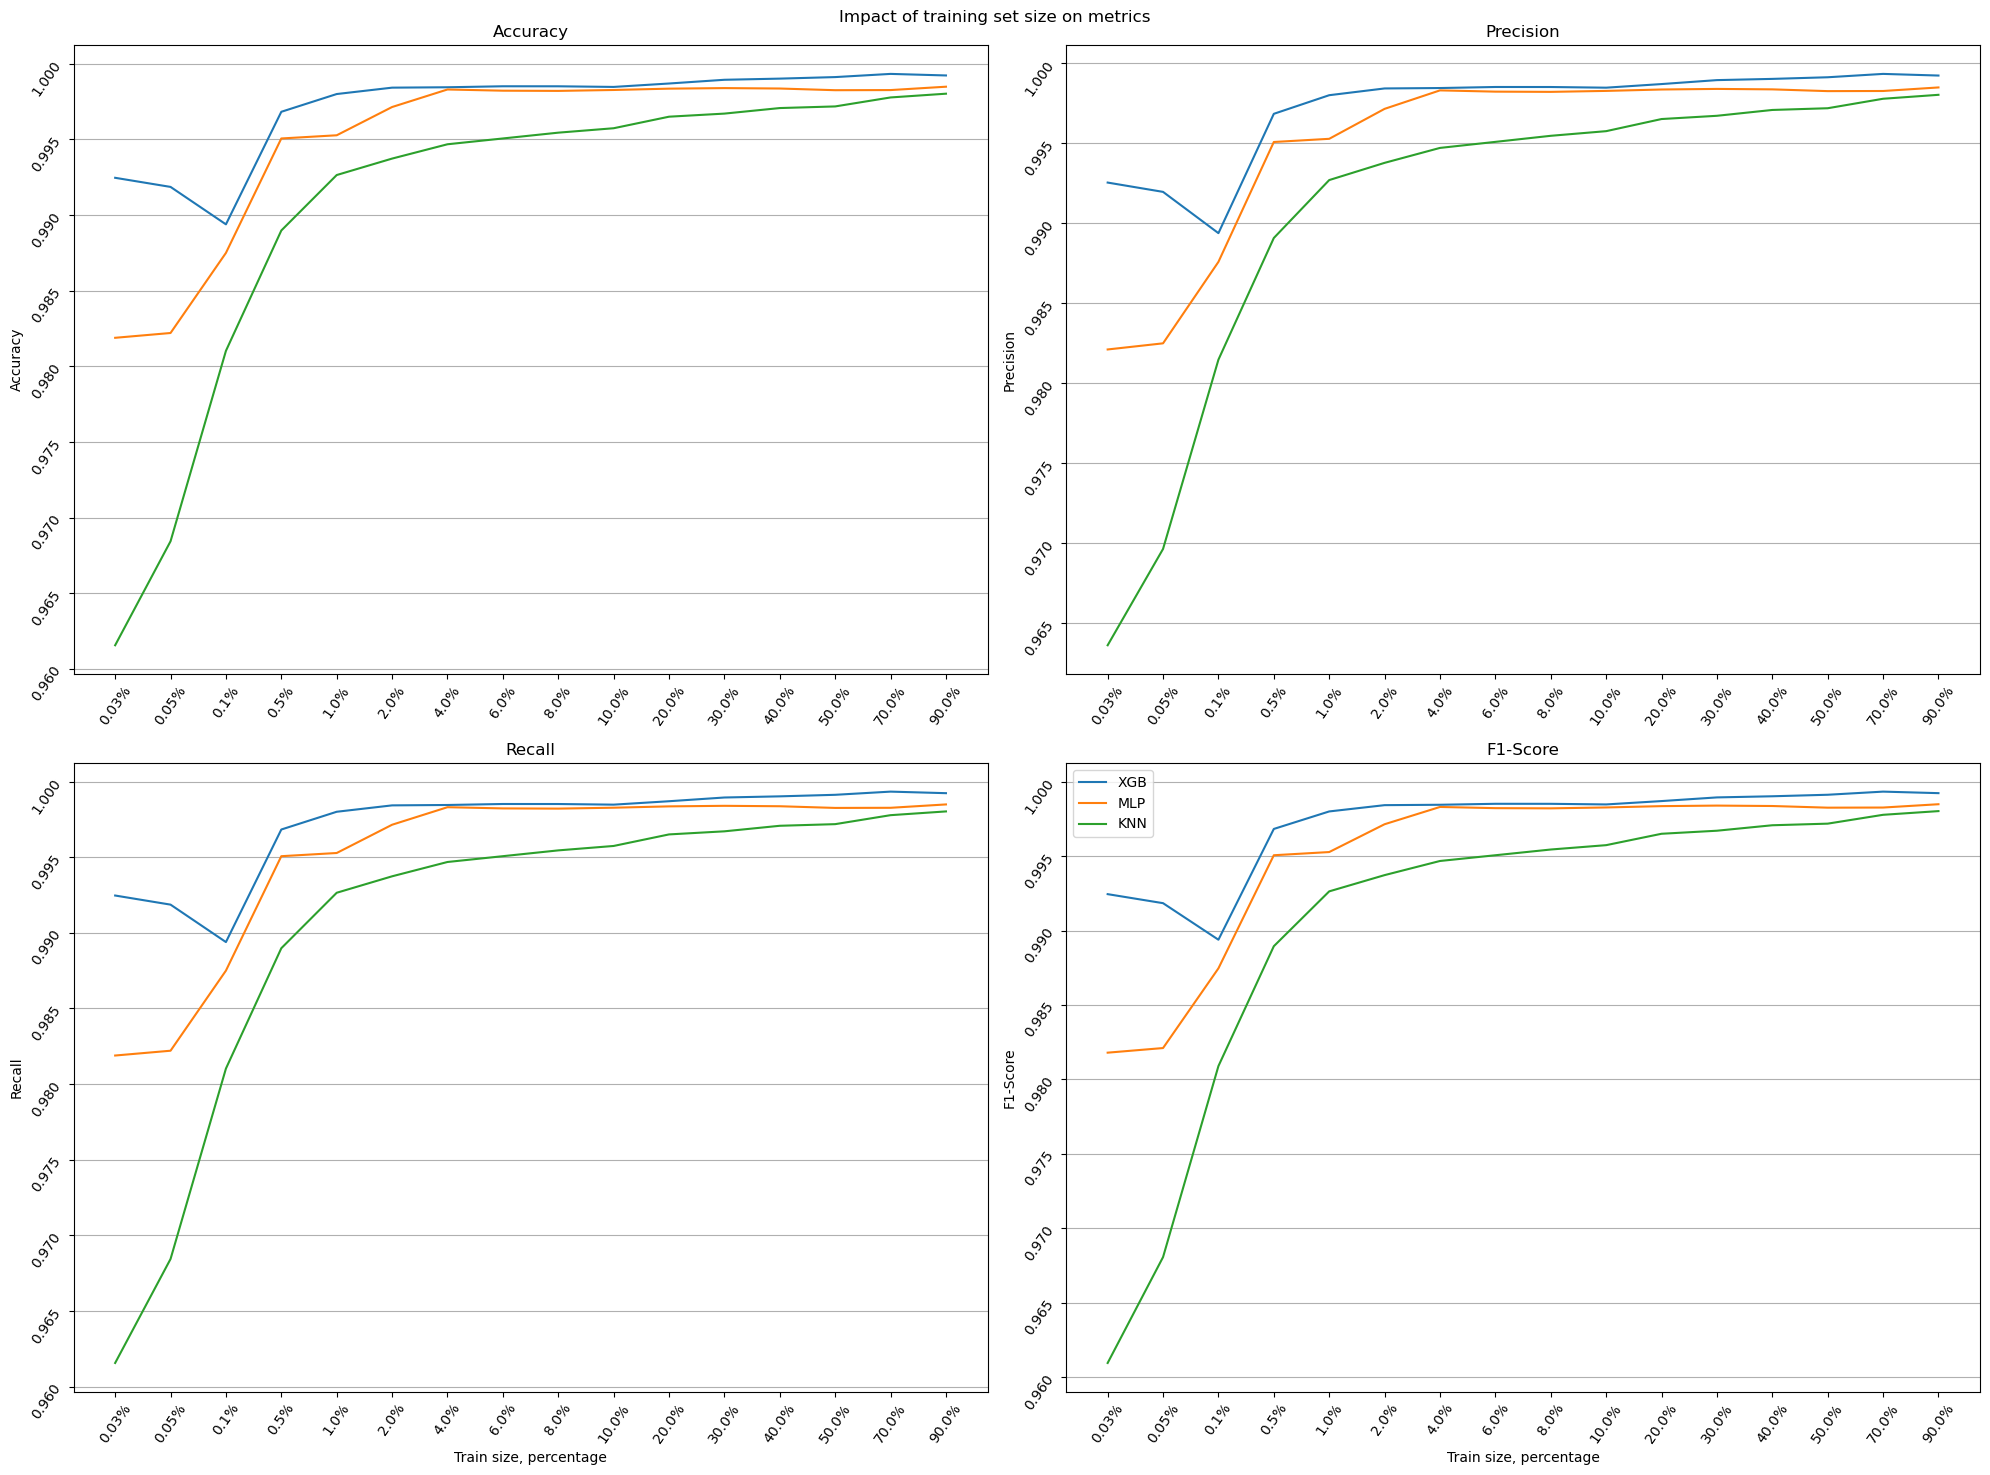

In [13]:
###############################################################################
###### Plot the 4 metrics vs training set size in 4 separate graphs
###############################################################################
        
xvalues=np.array(percentages_lables)
fig, axs = plt.subplots(2, 2, figsize=(20,15))

A_XGB = [item[0] for item in XGB_all_metrics]
A_DNN = [item[0] for item in DNN_all_metrics]
A_KNN = [item[0] for item in KNN_all_metrics]
axs[0,0].plot(xvalues, A_XGB, label = 'XGB')
axs[0,0].plot(xvalues, A_DNN, label = 'MLP')
axs[0,0].plot(xvalues, A_KNN, label = 'KNN')
axs[0,0].tick_params(labelrotation=55)
axs[0,0].set_title('Accuracy')
axs[0,0].set_ylabel('Accuracy')
axs[0,0].yaxis.grid(True)

GP_XGB = [item[1] for item in XGB_all_metrics]
GP_DNN = [item[1] for item in DNN_all_metrics]
GP_KNN = [item[1] for item in KNN_all_metrics]
axs[0,1].plot(xvalues, GP_XGB, label = 'XGB')
axs[0,1].plot(xvalues, GP_DNN, label = 'MLP')
axs[0,1].plot(xvalues, GP_KNN, label = 'KNN')
axs[0,1].tick_params(labelrotation=55)
axs[0,1].set_title('Precision')
axs[0,1].set_ylabel('Precision')
axs[0,1].yaxis.grid(True)

GR_XGB = [item[2] for item in XGB_all_metrics]
GR_DNN = [item[2] for item in DNN_all_metrics]
GR_KNN = [item[2] for item in KNN_all_metrics]
axs[1,0].plot(xvalues, GR_XGB, label = 'XGB')
axs[1,0].plot(xvalues, GR_DNN, label = 'MLP')
axs[1,0].plot(xvalues, GR_KNN, label = 'KNN')
axs[1,0].tick_params(labelrotation=55)
axs[1,0].set_title('Recall')
axs[1,0].set_ylabel('Recall')
axs[1,0].yaxis.grid(True)

GF1_XGB = [item[3] for item in XGB_all_metrics]
GF1_DNN = [item[3] for item in DNN_all_metrics]
GF1_KNN = [item[3] for item in KNN_all_metrics]
axs[1,1].plot(xvalues, GF1_XGB, label = 'XGB')
axs[1,1].plot(xvalues, GF1_DNN, label = 'MLP')
axs[1,1].plot(xvalues, GF1_KNN, label = 'KNN')
axs[1,1].tick_params(labelrotation=55)
axs[1,1].set_title('F1-Score')
axs[1,1].set_ylabel('F1-Score')
axs[1,1].yaxis.grid(True)

axs[1,0].set_xlabel('Train size, percentage')
axs[1,1].set_xlabel('Train size, percentage')


axs[1,1].legend(loc='best')
fig.suptitle('Impact of training set size on metrics')
    
fig.tight_layout()
fig.savefig(fig_folder+'/metrics.png')